In [109]:
import pandas as pd
import json
import numpy as np
import torch
from torch.autograd import Variable
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
repository = '/content/drive/MyDrive/MyDocuments/Academic/Education after grad/UCB/IEOR 2019/Academics/Capstone/Project/Git/DemandPredictionJD/'
%cd {repository} 
%ls -a

/content/drive/MyDrive/MyDocuments/Academic/Education after grad/UCB/IEOR 2019/Academics/Capstone/Project/Git/DemandPredictionJD
 capstone_jd_msom_data-minus-click-data/
'Clustering with K-prototype .ipynb'
 .git/
 initial_data_cleaning_order.ipynb
 Inventory_optimization.ipynb
 .ipynb_checkpoints/
 order_after_engineer.csv
 order_aggregation_Lei.ipynb
 order_dict.json
 PyTorch_models_Ben.ipynb
'PyTorch models - Lei.ipynb'
 README.md
 sku_clustering.csv
 sku_with_cluster.csv
 warehouse_capacity_preprocessing.ipynb


In [7]:
with open('order_dict.json') as f:
    data = json.load(f)

In [8]:
order_dict = {int(k):pd.DataFrame(v).set_index('day_of_month') for k, v in data.items()}

In [9]:
order_dict[1]

,demand,day_of_week,order_hour_mode,order_hour_08,order_hour_95,att1_high,att1_miss,att2_high,att2_miss,type_1_percent,no_promise,fast_promise,original_unit_price_mean,discount_rate_mean,direct_discount_rate_mean,quantity_discount_rate_mean,bundle_discount_mean,gift_mean,dc_ori_mode,dc_ori_num,cluster_id
day_of_month,,,,,,,,,,,,,,,,,,,,,
1,5,3,12,0.000000,1.000000,0.750000,0.250000,0.000000,0.750000,0.000000,0.750000,0.250000,121.475000,0.070538,0.061069,0.009470,0.000000,0.000000,7,1,0
1,18,3,5,0.444444,0.555556,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,7,1,1
1,57,3,23,0.111111,0.400000,0.488889,0.222222,0.333333,0.355556,0.933333,0.044444,0.888889,108.322222,0.468941,0.104816,0.238231,0.000000,0.044444,7,3,2
1,11,3,14,0.090909,0.636364,1.000000,0.000000,0.545455,0.090909,0.090909,0.636364,0.272727,144.081818,0.669827,0.568953,0.027548,0.000000,0.000000,7,1,3
1,58,3,12,0.111111,0.416667,0.777778,0.083333,0.500000,0.111111,0.333333,0.444444,0.472222,125.488889,0.421472,0.170375,0.178280,0.000000,0.000000,7,1,6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
31,39,5,14,0.028571,0.742857,0.400000,0.342857,0.628571,0.057143,0.057143,0.628571,0.171429,104.162857,0.335590,0.118868,0.003852,0.013378,0.028571,7,2,6
31,16,5,15,0.000000,0.866667,0.733333,0.200000,0.533333,0.200000,0.000000,1.000000,0.000000,1.200000,0.933333,0.000000,0.000000,0.000000,0.933333,7,1,7
31,26,5,13,0.090909,0.636364,0.590909,0.272727,0.454545,0.272727,0.727273,0.272727,0.727273,111.381818,0.412384,0.084126,NaN,0.039330,0.272727,1,3,8


In [10]:
df = order_dict[1].copy()
df = df.fillna(0)
df.replace(np.inf,0, inplace = True)

In [12]:
# convert data type for categorical features
df['cluster_id'] = df['cluster_id'].astype('object')
df['dc_ori_mode'] = df['dc_ori_mode'].astype('object')
df['day_of_week'] = df['day_of_week'].astype('object')
# order_hour_mode??

cat = ['cluster_id','dc_ori_mode','day_of_week']
num = df.drop(cat+['demand'], axis = 1).columns

In [14]:
# train test split
train = df.query('1<= day_of_month <= 24')
test = df.query('24 < day_of_month <= 31')

train_enc = pd.get_dummies(train, columns = cat)
test_enc = pd.get_dummies(test, columns = cat)

x_train = train_enc.drop('demand', axis = 1).to_numpy()
y_train = train_enc['demand'].to_numpy()

x_test = test_enc.drop('demand', axis = 1)
y_test = test_enc['demand']

In [120]:
# train_enc.dtypes
# x_train.float()
torch.from_numpy(x_train)

tensor([[12.0000,  0.0000,  1.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 5.0000,  0.4444,  0.5556,  ...,  0.0000,  0.0000,  0.0000],
        [23.0000,  0.1111,  0.4000,  ...,  0.0000,  0.0000,  0.0000],
        ...,
        [11.0000,  0.1000,  0.6000,  ...,  0.0000,  1.0000,  0.0000],
        [10.0000,  0.5000,  0.5000,  ...,  0.0000,  1.0000,  0.0000],
        [ 7.0000,  1.0000,  0.0000,  ...,  0.0000,  1.0000,  0.0000]],
       dtype=torch.float64)

In [16]:
# define model structure

class linearRegression(torch.nn.Module):
    def __init__(self, inputSize, outputSize):
        super(linearRegression, self).__init__()
        self.linear = torch.nn.Linear(inputSize, outputSize)

    def forward(self, x):
        out = self.linear(x)
        return out

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:520: UserWarning: Using a target size (torch.Size([198])) that is different to the input size (torch.Size([198, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


epoch 0, loss 1008.1329345703125
epoch 100, loss 297.1255187988281
epoch 200, loss 286.5893859863281
epoch 300, loss 278.92034912109375
epoch 400, loss 273.3361511230469
epoch 500, loss 269.267822265625


<module 'matplotlib.pyplot' from '/usr/local/lib/python3.7/dist-packages/matplotlib/pyplot.py'>

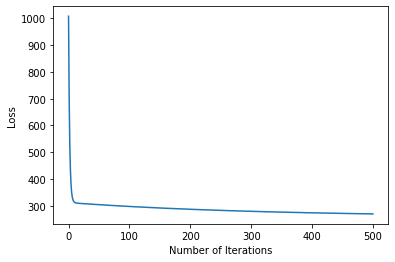

In [118]:
_, inputDim = x_train.shape
# inputDim = len(x_train.columns)     # takes variable 'x' 
outputDim = 1       # takes variable 'y'
learningRate = 0.00001          # <<== learning rate needs to be small enough?
epochs = 501
loss_list = []

model = linearRegression(inputDim, outputDim)
##### For GPU #######
if torch.cuda.is_available():
    model.cuda()

# ======================  TODO: replace MSELoss with SPO+ loss                  ========
# initialize the loss (Mean Squared Error) and optimization (Stochastic Gradient Descent)
criterion = torch.nn.MSELoss()                
optimizer = torch.optim.SGD(model.parameters(), lr=learningRate)

# model training

for epoch in range(epochs):
    # Converting inputs and labels to Variable
    if torch.cuda.is_available():
        inputs = Variable(torch.from_numpy(x_train).cuda())
        labels = Variable(torch.from_numpy(y_train).cuda())
    else:
        inputs = Variable(torch.from_numpy(x_train))
        labels = Variable(torch.from_numpy(y_train))

    # Clear gradient buffers because we don't want any gradient from previous epoch to carry forward, dont want to cummulate gradients
    optimizer.zero_grad()

    # get output from the model, given the inputs
    outputs = model(inputs.type(torch.FloatTensor))

    # get loss for the predicted output
    loss = criterion(outputs, labels.type(torch.FloatTensor))
    # get gradients w.r.t to parameters
    loss.backward()

    # update parameters
    optimizer.step()

    # store loss
    loss_list.append(loss.data)

    # print loss
    if(epoch % 100 == 0):
        print('epoch {}, loss {}'.format(epoch, loss.data))

plt.plot(range(epochs),loss_list)
plt.xlabel("Number of Iterations")
plt.ylabel("Loss")
plt

In [122]:
# bias b (offset or y-intercept)
print('y-intercept ', model.linear.bias.item())
# weight (w)
print('Weight ',  model.linear.weight.detach().numpy())

with torch.no_grad(): # we don't need gradients in the testing phase
    if torch.cuda.is_available():
        pred_y_train = model(Variable(torch.from_numpy(x_train).float().cuda())).cpu().data.numpy()
    else:
        pred_y_train = model(Variable(torch.from_numpy(x_train).float())).data.numpy()
pred_y_train = [pred_y_train[x].item() for x in range(len(pred_y_train))]

# Comparing Actual and predicted values
df = {}
df['Actual'] = y_train
df['Predicted'] = pred_y_train
df = pd.DataFrame(df)
print(df)

print('R^2 score ', r2_score(y_true=y_train, y_pred=pred_y_train))       # <<== negative R^2 score is pretty bad?


y-intercept  0.05479691922664642
Weight  [[ 0.31921074 -0.0503388  -0.01541324  0.03440157 -0.10012282  0.14083731
   0.09600756 -0.03096668  0.05735395  0.06097899  0.07328288  0.06353604
  -0.03947664 -0.03444362  0.15835057 -0.10489748  0.01685398  0.04567871
   0.12244647 -0.0650198   0.0117768  -0.11688489 -0.05605397  0.1445961
  -0.1346437  -0.03528053  0.07442206 -0.01042068 -0.15259662  0.08226706
   0.09684975 -0.00957103  0.14658493 -0.04994468 -0.00927317 -0.00243676
  -0.06813668 -0.07459725  0.11504237  0.06823411]]
     Actual  Predicted
0         5  12.981394
1        18   1.937235
2        57  15.439012
3        11  15.300266
4        58  13.201802
..      ...        ...
193      17  11.261586
194       5   5.653890
195      12   8.417309
196       2   8.191150
197       1   4.405385

[198 rows x 2 columns]
R^2 score  -0.15209015290797834


In [ ]:
'''
Ref:
https://medium.com/analytics-vidhya/linear-regression-with-pytorch-147fed55f138
https://linuxhint.com/pytorch_linear_regression_tutorial/
https://medium.com/biaslyai/pytorch-linear-and-logistic-regression-models-5c5f0da2cb9
https://towardsdatascience.com/linear-regression-with-pytorch-eb6dedead817
https://www.reneshbedre.com/blog/pytorch-regression.html
'''
